# Importing Libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, GRU
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import Flatten, Bidirectional, SpatialDropout1D
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping



In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# DATASET LOADING AND RESTRUCTURING

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Bracu/Summer 2022/CSE422/olid-training-v1.0.tsv', sep="\t")
df = df.drop(['id','subtask_b', 'subtask_c'], axis=1)
df.rename(columns = {'subtask_a':'label'}, inplace = True)


In [ ]:
df

,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT
...,...,...
13235,@USER Sometimes I get strong vibes from people...,OFF
13236,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT
13237,@USER And why report this garbage. We don't g...,OFF
13238,@USER Pussy,OFF


# DATASET PREPROCESSING

## BALANCING THE DATASET

In [4]:
df['label'].value_counts()

NOT    8840
OFF    4400
Name: label, dtype: int64

### Before Balancing The Dataset

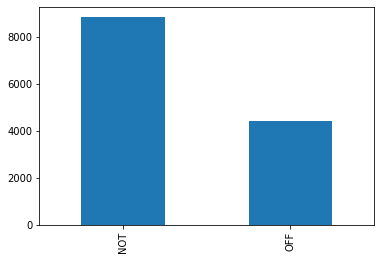

In [5]:
df['label'].value_counts().plot(kind = 'bar', label = ('Not Offensive', "Offensive"))


In [6]:
def balance_dataset(data):
  data_offensive = data[(data['label']=='OFF')]
  data_not_offensive = data[(data['label']=='NOT')]
  data_offensive_oversampled = resample(data_offensive, replace = True, n_samples = data['label'].value_counts()[0], random_state = 42)
  balanced_dataset = pd.concat([data_offensive_oversampled,data_not_offensive]).reset_index(drop=True)
  return balanced_dataset

In [7]:
df = balance_dataset(df)
df['label'].value_counts()

OFF    8840
NOT    8840
Name: label, dtype: int64

### After Balancing the Data Sense

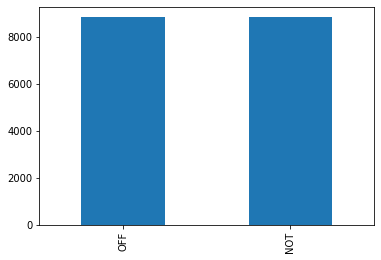

In [8]:
df['label'].value_counts().plot(kind = 'bar', label = ('Not Offensive', "Offensive"))

In [9]:
df

,tweet,label
0,A videographer who reported on the violence of...,OFF
1,@USER I love it that the wet liberals are so f...,OFF
2,@USER @USER Indoctrinated 🐑 programmed to beli...,OFF
3,@USER No one is open! You think he is sitting ...,OFF
4,@USER @USER The Pope is complicit. Make no m...,OFF
...,...,...
17675,@USER She is not the brightest light on the tree.,NOT
17676,@USER 😂😂😂😂😂😂 if I say you are mad now you will...,NOT
17677,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT
17678,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT


## Shuffling Dataset After Balancing

In [10]:
df = df.sample(frac=1).reset_index(drop=True)

In [11]:
df

,tweet,label
0,@USER Barf over the squishy self-righteous sou...,OFF
1,@USER Bigly....lol.....bigly? He didnt won...h...,OFF
2,@USER @USER @USER @USER She is on the march to...,NOT
3,@USER @USER @USER He doesn't care who he hurts...,NOT
4,@USER has clearly been compromised. He is supp...,NOT
...,...,...
17675,@USER Hey love just wanted to check on you!!! ...,NOT
17676,@USER @USER @USER @USER @USER That isn’t a bil...,OFF
17677,@USER @USER @USER Really? He is the only presi...,NOT
17678,@USER I think you are part of the Russia consp...,NOT


## Encoding the label

In [12]:
def label_encoder(x):
    if x == 'NOT': return 0
    else: return 1

In [13]:
df['label'] = df.label.apply(lambda x: label_encoder(x))

In [14]:
df

,tweet,label
0,@USER Barf over the squishy self-righteous sou...,1
1,@USER Bigly....lol.....bigly? He didnt won...h...,1
2,@USER @USER @USER @USER She is on the march to...,0
3,@USER @USER @USER He doesn't care who he hurts...,0
4,@USER has clearly been compromised. He is supp...,0
...,...,...
17675,@USER Hey love just wanted to check on you!!! ...,0
17676,@USER @USER @USER @USER @USER That isn’t a bil...,1
17677,@USER @USER @USER Really? He is the only presi...,0
17678,@USER I think you are part of the Russia consp...,0


## Preprocessing in input text


* removed link
* removed linebreaks
* removed extra spaces
* removed punctuation
* removed stopwords
* stemming
* lowercased the tweet
* extracted hashtags and added at the end of the sentence



In [15]:
df['tweet'][25]

'@USER Conservatives, if you are not a gun" person, I believe you need to become one. If these Nov. elections don\'t go well for the Dishonest Dems, I think the violence will get worse. All Conservatives will need to be able to defend themselves and their loved ones."'

In [16]:
port_stem = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [17]:
def clean_text(x):
    x = re.sub(r'https?://\S+', '', x) 
    x = re.sub(r'#\w+', '', x) 
    x = re.sub(r'\n',' ',x) 
    x = re.sub('\s+', ' ', x).strip()
    x = re.sub('\.','',x) 
    for p in string.punctuation:
        x = re.sub('\{}'.format(p),'',x)
    return x.lower()
    
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or ''

def pre_process_text(df):
    stop = stopwords.words('english')
    df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x))
    df['clean_tweet'] = df['clean_tweet'].apply(stemming)
    df['hashtags'] = df['tweet'].apply(lambda x: find_hashtags(x))
    df['clean_tweet_without_stopword'] = df['clean_tweet'].apply(lambda x:' '.join([word for word in x.split() if word not in stop]))
    df['final'] = df['clean_tweet_without_stopword']+" "+df['hashtags']
    return df

In [18]:
pdf = pre_process_text(df)
pdf

,tweet,label,clean_tweet,hashtags,clean_tweet_without_stopword,final
0,@USER Barf over the squishy self-righteous sou...,1,user barf squishi selfright sourc that whole d...,,user barf squishi selfright sourc whole deal t...,user barf squishi selfright sourc whole deal t...
1,@USER Bigly....lol.....bigly? He didnt won...h...,1,user biglylolbigli didnt wonh elect peopl unit...,,user biglylolbigli didnt wonh elect peopl unit...,user biglylolbigli didnt wonh elect peopl unit...
2,@USER @USER @USER @USER She is on the march to...,0,user user user user march match kinscem,,user user user user march match kinscem,user user user user march match kinscem
3,@USER @USER @USER He doesn't care who he hurts...,0,user user user doesnt care hurt long happi cou...,,user user user doesnt care hurt long happi cou...,user user user doesnt care hurt long happi cou...
4,@USER has clearly been compromised. He is supp...,0,user clearli compromis support behavior uncons...,,user clearli compromis support behavior uncons...,user clearli compromis support behavior uncons...
...,...,...,...,...,...,...
17675,@USER Hey love just wanted to check on you!!! ...,0,user hey love want check hope okay hun,,user hey love want check hope okay hun,user hey love want check hope okay hun
17676,@USER @USER @USER @USER @USER That isn’t a bil...,1,user user user user user bill lgbt sex worker ...,,user user user user user bill lgbt sex worker ...,user user user user user bill lgbt sex worker ...
17677,@USER @USER @USER Really? He is the only presi...,0,user user user realli presid hand come catastr...,,user user user realli presid hand come catastr...,user user user realli presid hand come catastr...
17678,@USER I think you are part of the Russia consp...,0,user think part russia conspiraci plenti evid ...,,user think part russia conspiraci plenti evid ...,user think part russia conspiraci plenti evid ...


## Vectorizing the text in TF-IDF vectorizer (Trigram)

In [19]:
tf_idf = TfidfVectorizer(ngram_range=(1,3))
X = tf_idf.fit_transform(pdf['final'])
Y = pdf.label


# SPLITING THE DATASET

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle = True)

# TRAINING THE MACHINE LEARNING MODEL


1.   Logistic Regression
2.   Support Vector Machine
3.   Naive Bayes



In [ ]:
model_LR = LogisticRegression().fit(X_train,Y_train)
model_SVM = SVC(kernel='rbf', random_state = 42).fit(X_train, Y_train)
model_NB = ComplementNB().fit(X_train,Y_train)

# SCORE ON TEST SET

In [ ]:
LR_score = classification_report(Y_test, model_LR.predict(X_test))
SVC_score = classification_report(Y_test, model_SVM.predict(X_test))
NB_score = classification_report(Y_test, model_NB.predict(X_test))
print("LOGISTIC REGRESSION")
print(LR_score)
print("SUPPORT VECTOR CLASSIFICATION")
print(SVC_score)
print("NAIVE BAYES CLASSIFICATION")
print(NB_score)

LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1808
           1       0.88      0.84      0.86      1728

    accuracy                           0.87      3536
   macro avg       0.87      0.87      0.87      3536
weighted avg       0.87      0.87      0.87      3536

SUPPORT VECTOR CLASSIFICATION
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1808
           1       0.98      0.85      0.91      1728

    accuracy                           0.91      3536
   macro avg       0.92      0.91      0.91      3536
weighted avg       0.92      0.91      0.91      3536

NAIVE BAYES CLASSIFICATION
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1808
           1       0.76      0.92      0.83      1728

    accuracy                           0.82      3536
   macro avg       0.83      0.82      0.81      35

# DEEP LEARNING PART

In [20]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.8.2
Running on TPU  ['10.13.218.10:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.13.218.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.218.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [21]:
pdf['final'].apply(lambda x:len(str(x).split())).max()

80

In [22]:
Y = pd.get_dummies(pdf['label']).values
print('Shape of label tensor:', Y.shape)
X = pdf['final']

Shape of label tensor: (17680, 2)


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.8, random_state=42, shuffle = True)


In [24]:
maxlen = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)

X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [25]:
def create_embedding_matrix(filepath, word_idx, embedding_dim):
    vocab_size = len(word_idx) + 1  
    emb = np.zeros((vocab_size, embedding_dim))
    with open(filepath, 'r', encoding="utf8") as f:
        for i in f:
            x = i.split(' ')
            w, v = x[0], x[1:]
            if w in word_idx:
                emb[word_idx[w]] = np.asarray(v)[:embedding_dim]
    return emb

In [26]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix('/content/drive/MyDrive/Bracu/Spring2022/CSE440/Project/Dataset/glove.840B.300d.txt', tokenizer.word_index, embedding_dim)


In [38]:
with tpu_strategy.scope():
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=maxlen, 
                            trainable=False))
  model.add(Bidirectional(LSTM(300, dropout=0.2, recurrent_dropout=0.2)))
  model.add(Dense(300,activation = 'relu'))
  model.add(Dropout(0.3))
  # model.add(Dense(150,activation = 'relu'))
  # model.add(Dropout(0.3))
  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          4404600   
                                                                 
 bidirectional_4 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 300)               180300    
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                                 
 dense_10 (Dense)            (None, 2)                 602       
                                                                 
Total params: 6,027,902
Trainable params: 1,623,302
Non-trainable params: 4,404,600
____________________________________

In [41]:
epochs = 100
batch_size = 512*tpu_strategy.num_replicas_in_sync
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.15,callbacks=[EarlyStopping(monitor='val_loss', patience=15, min_delta=0.0001)])


Epoch 1/100
3/3 [==============================] - 1s 507ms/step - loss: 0.1465 - accuracy: 0.9442 - val_loss: 0.5363 - val_accuracy: 0.8450
Epoch 2/100
3/3 [==============================] - 1s 472ms/step - loss: 0.1467 - accuracy: 0.9448 - val_loss: 0.5438 - val_accuracy: 0.8525
Epoch 3/100
3/3 [==============================] - 1s 477ms/step - loss: 0.1420 - accuracy: 0.9451 - val_loss: 0.5657 - val_accuracy: 0.8454
Epoch 4/100
3/3 [==============================] - 1s 477ms/step - loss: 0.1307 - accuracy: 0.9515 - val_loss: 0.5756 - val_accuracy: 0.8431
Epoch 5/100
3/3 [==============================] - 1s 469ms/step - loss: 0.1313 - accuracy: 0.9501 - val_loss: 0.5892 - val_accuracy: 0.8501
Epoch 6/100
3/3 [==============================] - 1s 471ms/step - loss: 0.1286 - accuracy: 0.9501 - val_loss: 0.5538 - val_accuracy: 0.8553
Epoch 7/100
3/3 [==============================] - 2s 808ms/step - loss: 0.1281 - accuracy: 0.9510 - val_loss: 0.6256 - val_accuracy: 0.8450
Epoch 8/100
3

In [42]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

111/111 [==============================] - 4s 29ms/step - loss: 0.7043 - accuracy: 0.8312
Test set
  Loss: 0.704
  Accuracy: 0.831
111/111 [==============================] - 4s 27ms/step - loss: 0.7043 - accuracy: 0.8312
Test set
  Loss: 0.704
  Accuracy: 0.831
